# Project Team: Walking in Paris

### Objective:
Identify the attributes that make Airbnb “Successful” 
Find the best place to stay in Hawaii

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

# Import statistic library
import scipy.stats as stats
from scipy.stats import linregress

# Import seaborn library to create figure
import seaborn as sns

import pprint
import json
from time import sleep
from datetime import date
import zipfile

# Incorporated citipy to determine city based on latitude and longitude
# pip install citipy
from citipy import citipy

# Output File location
output_folder = "output_data"

In [2]:
# Open the zip file
zf = zipfile.ZipFile('./source_data/detail_listings.zip') 
df = pd.read_csv(zf.open('detail_listings.csv'), low_memory=False)

rows_in_df = len(df)
print(f'Data set has {rows_in_df} rows')

# Drop unneeded columns:
df = df.drop(columns = [
    "listing_url", 
    "thumbnail_url", 
    "picture_url", 
    "medium_url", 
    "xl_picture_url", 
    "host_url", 
    "host_thumbnail_url", 
    "host_picture_url", 
    "scrape_id",
    "host_listings_count", # There is a host_total_listings_count that is a dupe
    "host_acceptance_rate", # NaN
    "calendar_last_scraped",
    "bed_type",
    "last_scraped",
    "calendar_updated",
    "has_availability",
    "availability_30", 
    "availability_60", 
    "availability_90", 
    "availability_365", 
    "license"
])

df.head(1)

Data set has 23745 rows


,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,f,f,moderate,f,f,2,2,0,0,0.45


In [3]:
# Group the columns and show the list of the columns
        
print('')
print('----------------------')
print('Property-specific columns:')
print('----------------------')
# These are wildcard search terms:
cols = ["experiences_offered", "street", "city", "state", "zipcode", "market", "country", "property"
    , "location", "accomodate", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"]
for col in df.columns: 
    if col in cols:
        print(col) 
        
print('')
print('----------------------')
print('All columns:')
print('----------------------')
for col in df.columns: 
    print(col)


----------------------
Property-specific columns:
----------------------
experiences_offered
street
city
state
zipcode
market
country
instant_bookable
is_business_travel_ready

----------------------
All columns:
----------------------
id
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
host_id
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
m

In [4]:
# Create a dataframe with 1 row for each column in the source:
data_dict = pd.DataFrame(columns = [
    "ColumNumber"
    , "Column"
    , "Group"
    , "Subgroup"
    , "Notes"
])

# Loop through 
for column in df:
    data_dict = data_dict.append({
            "Column": column
            , "Group": ""
            , "Subgroup": ""
            , "Notes": ""
        }
        , ignore_index=True
    )

# Make the index the column numebr
data_dict['ColumNumber'] = data_dict.index
        
# Add context for each column 
for index, row in data_dict.iterrows():
    val = str(row["Column"])
    
    if val == "id":
        data_dict.loc[index, "Notes"] = "Primary Key"
    # Val.startswith("host_")  
    if val.find("host") > -1: 
        data_dict.loc[index, "Group"] = "Host-related"
    
    if val.find("review") > -1:
        data_dict.loc[index, "Group"] = "Review-related"
        
    if (val.find("rule") > -1) | (val.find("require") > -1):
        data_dict.loc[index, "Group"] = "Requirements-related"
        
    if (val.find("neighbo") > -1):
        data_dict.loc[index, "Group"] = "Neighborhood-related"
        
    if (val.find("nights") > -1):
        data_dict.loc[index, "Group"] = "Booking-related"
        
    # Property specific:
    cols = [
        "property", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"
        , "space", "name", "summary", "description", "notes", "transit", "access", "interaction"
        , "property_type", "room_type", "amenities"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        
    # Property - "Location" specific:
    cols = [
        "location", "street", "city", "state", "zipcode", "market", "country"
        , "latitude", "longitude", "is_location_exact"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Location"
        
    # Property - "Interior" specific:
    cols = [
        "bathrooms", "bedrooms", "beds", "square_feet"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Interior"
        
    # Property - "Pricing" specific:
    # Things about price, or that we might associate with price
    cols = [
        "price", "weekly_price", "monthly_price"        
        , "security_deposit", "cleaning_fee"
        , "accomodates", "guests_included", "extra_people"
        , "experiences_offered"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
    # Add additional code to accomodate a group and subgroup of properties:
    if val == "accommodates":
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
print(data_dict.groupby(["Group", "Subgroup"])["Column"].count())
print('')
print('Columns without a group:')
data_dict[data_dict["Group"] == ""]


Group                 Subgroup
                                   1
Booking-related                    8
Host-related                      12
Neighborhood-related               5
Property-related                  20
                      Interior     4
                      Location    13
                      Pricing      9
Requirements-related               2
Review-related                    11
Name: Column, dtype: int64

Columns without a group:


,ColumNumber,Column,Group,Subgroup,Notes
0,0,id,,,Primary Key


Making additional cleaning of the raw data in the rows
- Drop rows with number_of_reviews = 0
- Get names of indexes for which column number_of_reviews has value 0
- Strip out the dollar symboil ($) from the pricing based columns:
  price","weekly_price","monthly_price","security_deposit","cleaning_fee", "extra_people"  


In [5]:
# Drop by index:
indexNames = df[df['number_of_reviews'] == 0 ].index
df.drop(indexNames , inplace=True)

# Drop rows with number_of_reviews = NaN
df.dropna(axis=0, subset=('number_of_reviews', ))

# Drop rows with NaN review data
df.dropna(axis=0, subset=(
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_location', 
    'review_scores_value'
))

print(f'Remaining rows after cleanup: {len(df)}')

Remaining rows after cleanup: 18291


In [6]:
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

if df["price"].dtype != "float64":
    df["price"] = df["price"].str.replace("$", "")
    df["price"] = df["price"].str.replace(",", "")
    df["price"] = df["price"].astype("float64")

if df["weekly_price"].dtype != "float64":
    df["weekly_price"] = df["weekly_price"].str.replace("$", "")
    df["weekly_price"] = df["weekly_price"].str.replace(",", "")
    df["weekly_price"] = df["weekly_price"].astype("float64")

if df["monthly_price"].dtype != "float64":
    df["monthly_price"] = df["monthly_price"].str.replace("$", "")
    df["monthly_price"] = df["monthly_price"].str.replace(",", "")
    df["monthly_price"] = df["monthly_price"].astype("float64")
    
if df["security_deposit"].dtype != "float64":
    df["security_deposit"] = df["security_deposit"].str.replace("$", "")
    df["security_deposit"] = df["security_deposit"].str.replace(",", "")
    df["security_deposit"] = df["security_deposit"].astype("float64")
    
if df["cleaning_fee"].dtype != "float64":
    df["cleaning_fee"] = df["cleaning_fee"].str.replace("$", "")
    df["cleaning_fee"] = df["cleaning_fee"].str.replace(",", "")
    df["cleaning_fee"] = df["cleaning_fee"].astype("float64")   

if df["extra_people"].dtype != "float64":
    df["extra_people"] = df["extra_people"].str.replace("$", "")
    df["extra_people"] = df["extra_people"].str.replace(",", "")
    df["extra_people"] = df["extra_people"].astype("float64")
    
data_dict

,ColumNumber,Column,Group,Subgroup,Notes
0,0,id,,,Primary Key
1,1,name,Property-related,,
2,2,summary,Property-related,,
3,3,space,Property-related,,
4,4,description,Property-related,,
...,...,...,...,...,...
80,80,calculated_host_listings_count,Host-related,,
81,81,calculated_host_listings_count_entire_homes,Host-related,,
82,82,calculated_host_listings_count_private_rooms,Property-related,,
83,83,calculated_host_listings_count_shared_rooms,Property-related,,


In [7]:
# Create the bins to separate the number of properties by host
bins = [0, 50, 100, 150, 200, 250, 299]

# labels - always one less than the range
group_names = ["0-50 properties", "51-100 properties", "101-150 properties", "151-200 properties",\
               "201-250 properties", "251+ properties"]

df["Bin_NumProperties"] = pd.cut(df["calculated_host_listings_count"], bins, labels=group_names)


# Loop through and get aggs:
total_reviews_per_host = df.groupby("host_id").sum()["number_of_reviews"]
average_review_per_host = df.groupby("host_id").mean()["review_scores_rating"]
rating_mean_by_bin = df.groupby("Bin_NumProperties").mean()["review_scores_rating"]

#df_analyze["rating_value_mean"] = df_analyze["review_scores_value"].mean()
df.head(1)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumProperties
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,f,moderate,f,f,2,2,0,0,0.45,0-50 properties


In [8]:
# data_dict[data_dict["Group"] == "Host-related"]
host_group = df.groupby("neighbourhood").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

host_group.rename(columns={'count_nonzero':'Reviews'})
host_group.head()
# bin on reviews_per_month

number_of_reviews                    \
                                      count_nonzero       mean median   
neighbourhood                                                           
Aiea                                             14  40.428571    8.0   
Airport                                           3   4.000000    4.0   
Ala Moana/Kakaako                                28  23.214286    8.5   
Aliamanu/Salt Lake/Foster Village                 8  74.875000    9.5   
Central Oahu                                     43  29.302326   17.0   

                                                             
                                            var         std  
neighbourhood                                                
Aiea                                2872.417582   53.594940  
Airport                                9.000000    3.000000  
Ala Moana/Kakaako                   1138.767196   33.745625  
Aliamanu/Salt Lake/Foster Village  17739.267857  133.188843  
Central Oahu                        1214.073090   34.843552

In [9]:
bins_num_reviews = [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 550, 600, 100000]

# labels - always one less than the range
group_names_num_reviews = [
    "1-10"
    , "11-20"
    , "21-50"
    , "100-200"
    , "201-250"
    , "251-300"
    , "301-350"
    , "351-400"
    , "401-550"
    , "451-500"
    , "501-550"
    , "551-600"
]

df["Bin_NumReviews"] = pd.cut(
    df["number_of_reviews"], 
    bins = bins_num_reviews, 
    labels = group_names_num_reviews
)

df["Bin_NumReviews"].value_counts()


11-20      3790
1-10       2526
21-50      2368
100-200    1235
201-250     250
251-300      32
301-350      23
351-400      10
401-550       6
551-600       3
451-500       3
501-550       1
Name: Bin_NumReviews, dtype: int64

In [10]:
print(f'Sum: {df["number_of_reviews"].sum()}')
print(f'Count: {df["number_of_reviews"].count()}')

df.groupby("Bin_NumReviews")["number_of_reviews"].sum()

Sum: 623494
Count: 18291


Bin_NumReviews
1-10        37991
11-20      126389
21-50      169320
100-200    169224
201-250     59598
251-300     10221
301-350      8452
351-400      4217
401-550      2864
451-500      1561
501-550       569
551-600      1983
Name: number_of_reviews, dtype: int64

In [11]:
df.groupby("Bin_NumReviews").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

number_of_reviews                                          
                   count_nonzero        mean median         var        std
Bin_NumReviews                                                            
1-10                        2526   15.039984   15.0    8.161173   2.856777
11-20                       3790   33.348021   32.0   74.548947   8.634173
21-50                       2368   71.503378   70.0  197.305439  14.046545
100-200                     1235  137.023482  131.0  741.095883  27.223076
201-250                      250  238.392000  232.0  802.456161  28.327657
251-300                       32  319.406250  318.0  176.958669  13.302581
301-350                       23  367.478261  366.0  157.988142  12.569333
351-400                       10  421.700000  421.5  252.900000  15.902830
401-550                        6  477.333333  485.5  246.666667  15.705625
451-500                        3  520.333333  518.0   24.333333   4.932883
501-550                        1  569.000000  569.0         NaN        NaN
551-600                        3  661.000000  669.0  577.000000  24.020824

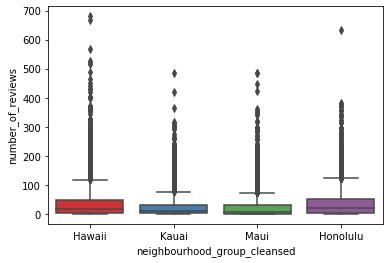

In [13]:
# Use seaborn library to create a boxplot
# sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "number_of_reviews",
    #hue = "price",
    data = df,
    palette = "Set1"
)

# Bin by island
# data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

In [14]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

is_string_dtype(df['price'])
is_numeric_dtype(df['price'])
df["price"]

0         85.0
1        110.0
2         92.0
3        299.0
4         92.0
         ...  
23569    111.0
23576     79.0
23582     70.0
23656    146.0
23741    499.0
Name: price, Length: 18291, dtype: float64

In [15]:
# Bin by island
isle = df[['latitude', 'longitude']].head(50).copy()
isle["Island"] = ""

curr_rows = len(isle)
print(f'There are {curr_rows} coordinates in the dataframe')

df["neighbourhood_group_cleansed"]

There are 50 coordinates in the dataframe


0          Hawaii
1          Hawaii
2          Hawaii
3          Hawaii
4           Kauai
           ...   
23569        Maui
23576      Hawaii
23582    Honolulu
23656    Honolulu
23741       Kauai
Name: neighbourhood_group_cleansed, Length: 18291, dtype: object

Evaluate dataset to identify variables that are correlated

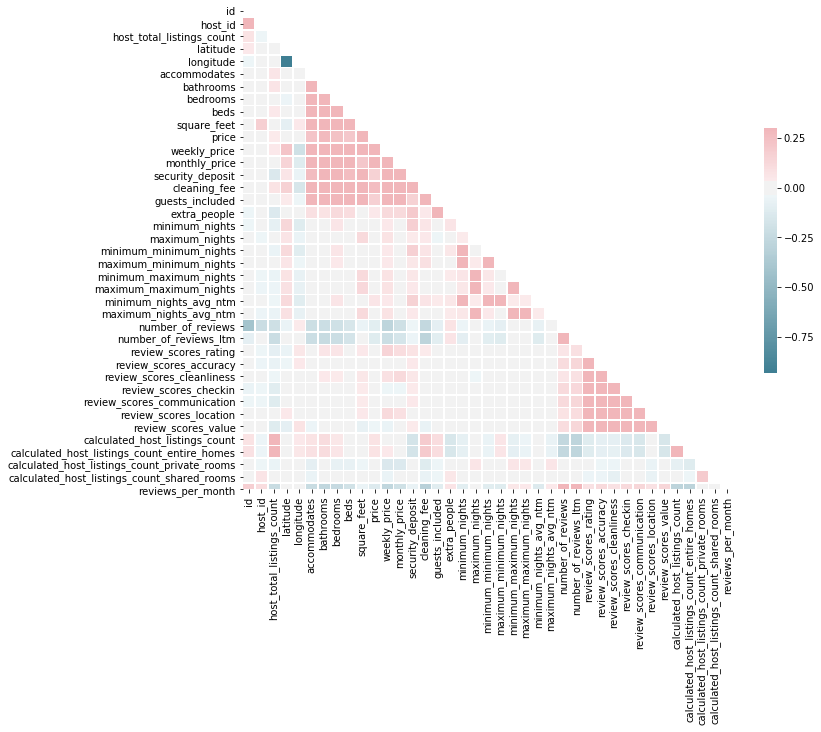

In [57]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

In [58]:
df.loc[:,data_dict[data_dict["Group"] == "Host-related"]["Column"]]

,host_id,host_since,host_about,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes
0,7257,2009-01-31,HI\r\nWE LIVE HERE IN HONOKAA ON \r\nFARM JUS...,within a day,100%,f,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,2,2
1,7620,2009-02-09,"Lea, born and raised on the Island of Hawaii, ...",within an hour,100%,f,5.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,f,5,4
2,7878,2009-02-13,"Kona Hawaii,\r\n \r\n Ed is a Farmer/Designer ...",within an hour,100%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,3,3
3,7878,2009-02-13,"Kona Hawaii,\r\n \r\n Ed is a Farmer/Designer ...",within an hour,100%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,3,3
4,7887,2009-02-14,NaN,within a few hours,100%,f,2.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
23569,304920835,2019-10-27,NaN,within an hour,100%,f,0.0,"['email', 'phone']",t,f,3,1
23576,157833059,2017-11-07,NaN,within an hour,100%,t,3.0,"['email', 'phone', 'reviews', 'offline_governm...",t,f,3,0
23582,311670041,2019-11-23,Laid-back retired veteran and now enjoying the...,within an hour,100%,f,1.0,"['email', 'phone', 'offline_government_id', 'g...",t,f,1,0
23656,43793840,2015-09-09,Real Estate Broker,within an hour,100%,f,105.0,"['email', 'phone', 'reviews', 'kba']",t,f,105,105


Below we are testing the hypothesis 1:
If a host has a hugh number of properties then their ratings are not higher than hosts with fewer properties

In [17]:
# Define the bins by number of properties by host
bins = [0, 50, 100, 150, 200, 250, 299]

# labels - always one less than the range
group_names = ["0-50 properties", "51-100 properties", "101-150 properties", "151-200 properties",\
               "201-250 properties", "251+ properties"]

df["Bin_NumProperties"] = pd.cut(df["calculated_host_listings_count"], bins, labels=group_names)

rating_mean_by_bin = df.groupby("Bin_NumProperties").mean()["review_scores_rating"]

df.head(2)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumProperties,Bin_NumReviews
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,moderate,f,f,2,2,0,0,0.45,0-50 properties,11-20
1,5269,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","The ‘Auwai Suite is a lovely, self-contained a...","The 'Auwai Suite is a lovely, self-contained a...",none,"We are located on the ""sunny side"" of Waimea, ...",NaN,One parking spot is provided with your stay.,You'll have access to your private garden suit...,...,strict_14_with_grace_period,f,f,5,4,1,0,0.09,0-50 properties,NaN


<function matplotlib.pyplot.show(*args, **kw)>

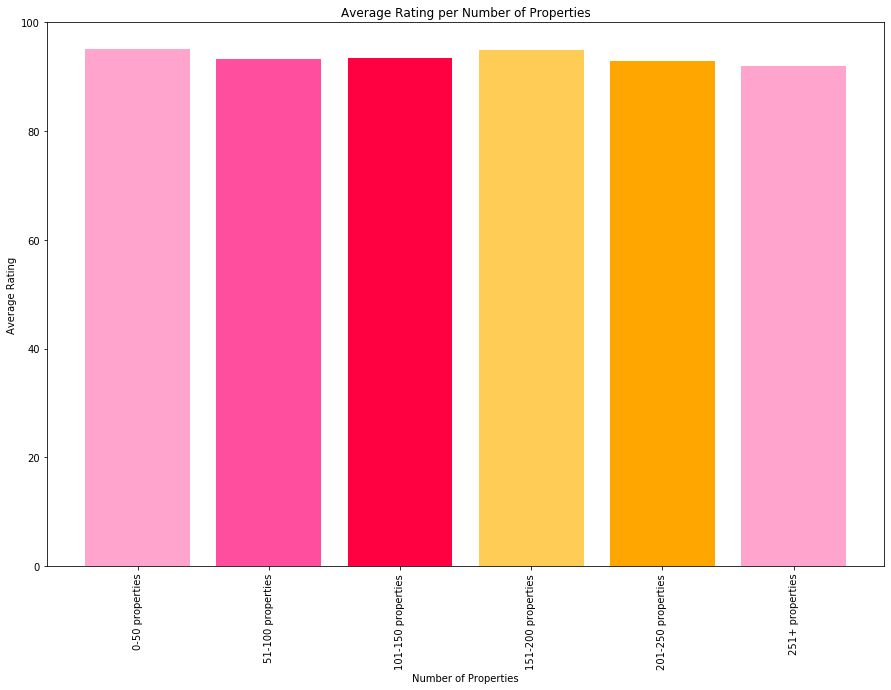

In [20]:
# Define the axis
x_axis = group_names
y_axis = rating_mean_by_bin

# Bring in the colors from Hawaii
hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

# Define the properties of the figure

plt.subplots(figsize=(15,10))
plt.title("Average Rating per Number of Properties")
plt.xlabel("Number of Properties")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)

# Show the figure
plt.show

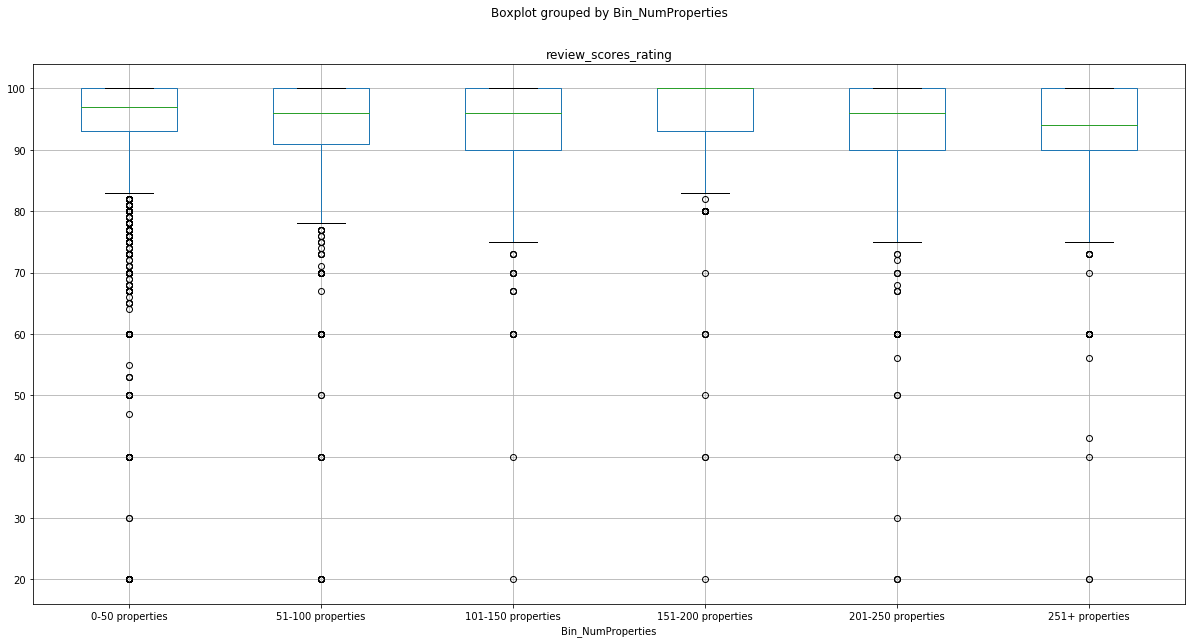

In [21]:
df.boxplot("review_scores_rating", by="Bin_NumProperties", figsize=(20, 10))

In [22]:
# Extract individual groups
group1 = df[df["Bin_NumProperties"] == "0-50 properties"]["review_scores_rating"].dropna()
group2 = df[df["Bin_NumProperties"] == "51-100 properties"]["review_scores_rating"].dropna()
group3 = df[df["Bin_NumProperties"] == "101-150 properties"]["review_scores_rating"].dropna()
group4 = df[df["Bin_NumProperties"] == "151-200 properties"]["review_scores_rating"].dropna()
group5 = df[df["Bin_NumProperties"] == "201-250 properties"]["review_scores_rating"].dropna()
group6 = df[df["Bin_NumProperties"] == "251+ properties"]["review_scores_rating"].dropna()

stats.f_oneway(group1, group2, group3, group4, group5, group6)

F_onewayResult(statistic=43.20051018106537, pvalue=1.9870577727779467e-44)

<function matplotlib.pyplot.show(*args, **kw)>

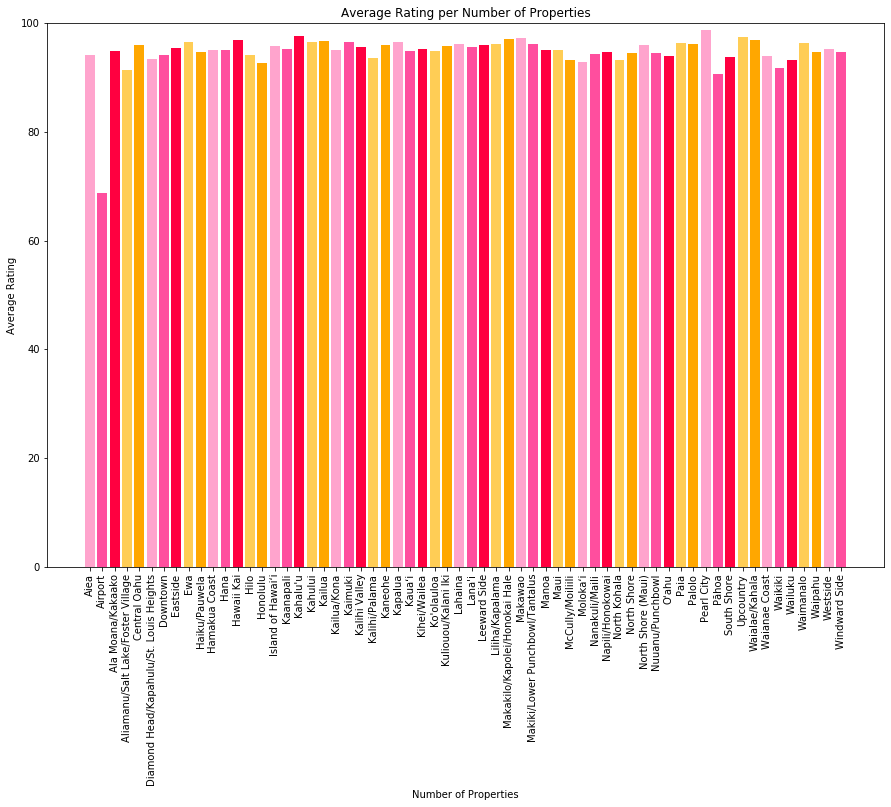

In [23]:
neighborhood_list = df["neighbourhood"].unique()

average_rating_per_neighborhood = df.groupby("neighbourhood").mean()["review_scores_rating"]
average_rating_per_neighborhood

x_axis = neighborhood_list
y_axis = average_rating_per_neighborhood

cleaned_neighborhood_list = [x for x in neighborhood_list if str(x) != 'nan']
cleaned_neighborhood_list.sort()
cleaned_neighborhood_list

x_axis = cleaned_neighborhood_list
y_axis = average_rating_per_neighborhood

hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.title("Average Rating per Number of Properties")
plt.xlabel("Number of Properties")
plt.ylabel("Average Rating")
plt.ylim(0, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette, align='center')
plt.show

The r-squared is: 0.018787686050668887


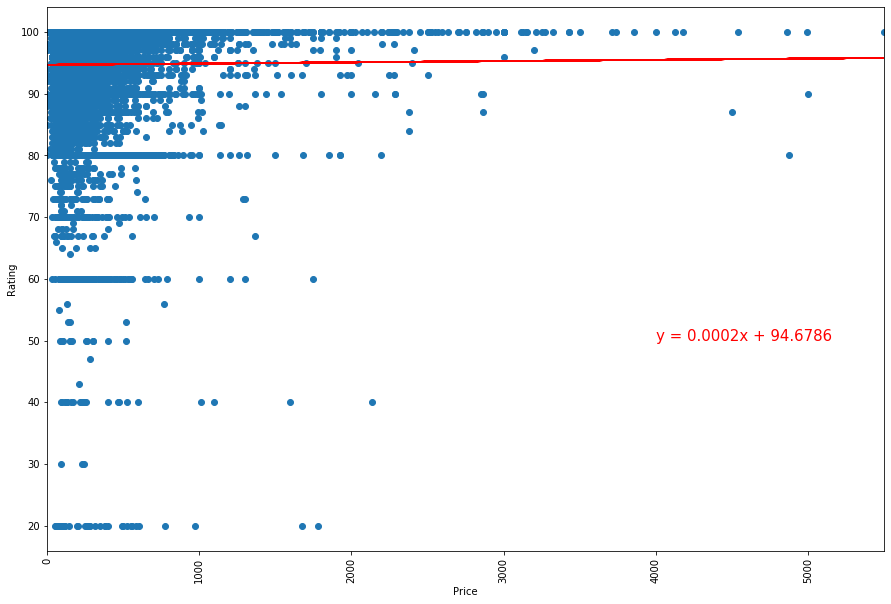

In [24]:
# Define axis
x_axis = df["price"]
y_axis = df["review_scores_rating"]


mask = ~np.isnan(x_axis) & ~np.isnan(y_axis)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis[mask], y_axis[mask])
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,4))

plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.xlim(0, 5500)
plt.plot(x_axis,regress_values,"r-")
plt.scatter(x_axis,y_axis)
plt.annotate(line_eq,(4000,50),fontsize=15,color="red")
plt.xlabel('Price')
plt.ylabel('Rating')
print(f"The r-squared is: {r_value}")
plt.show()

In [25]:
# create a dataframe with no 0's for 'number of beds' becuase that would be inaccurate data
df2 = df.copy()
df2 = df2[(df2['beds'] != 0)]

In [26]:
# zero beds is actually an option. A 'sofa bed' is not a real bed and is not counted as such.
bins = [0, 2, 4, 6, 8, 10, 12, 20]

group_names = ["1-2 beds", "3-4 beds", "5-6 beds", "7-8 beds", "9-10 beds", "11-12 beds", "13+ beds"]

df2["bin_bed_count"] = pd.cut(df2["beds"], bins, labels=group_names)

rating_mean_by_bed_count = df2.groupby("bin_bed_count").mean()["review_scores_rating"]

<function matplotlib.pyplot.show(*args, **kw)>

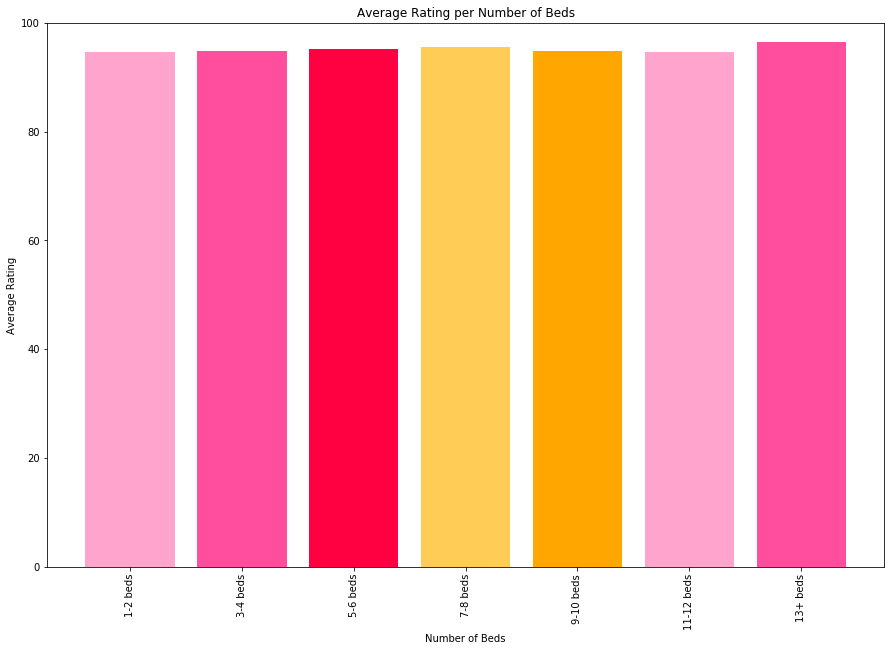

In [53]:
x_axis = group_names
y_axis = rating_mean_by_bed_count

hawaiian_hex_palette = ["#00739f", "#b23948", "#ff000e", "#ff407c", "#ffb2e1"]

plt.subplots(figsize=(15,10))
plt.title("Average Rating per Number of Beds")
plt.xlabel("Number of Beds")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

In [31]:
average_rating_island = df.groupby("neighbourhood_group_cleansed").mean()["review_scores_rating"]
properties_island = df.groupby("neighbourhood_group_cleansed").count()["id"]
average_rating_island.head()

neighbourhood_group_cleansed
Hawaii      95.482990
Honolulu    93.691277
Kauai       94.907945
Maui        95.159183
Name: review_scores_rating, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

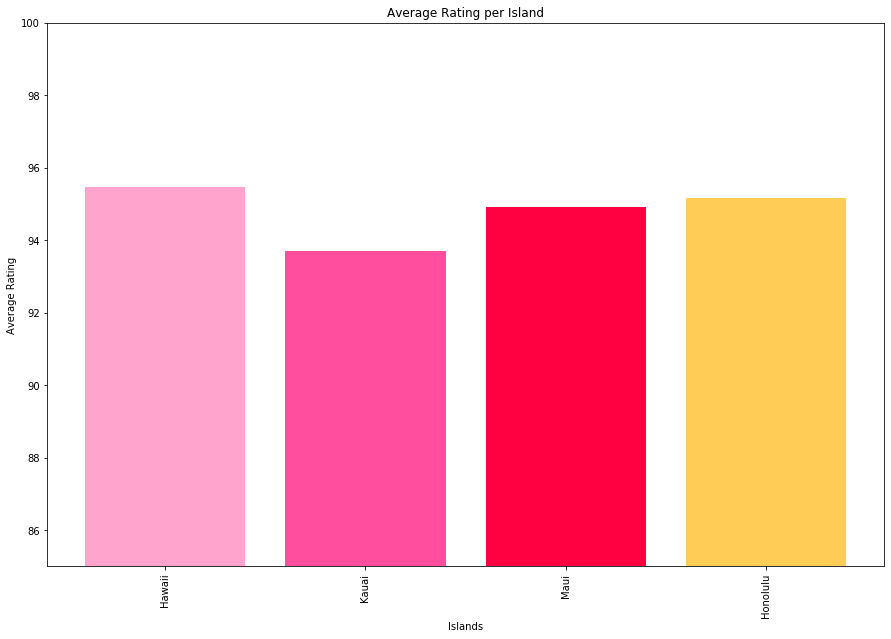

In [56]:
# set x and y axis for bar graph
x_axis = df["neighbourhood_group_cleansed"].unique()
y_axis = average_rating_island

# Define the properties of the figure
plt.subplots(figsize=(15,10))

# print lables/title and x/y limits to improve visual
plt.title("Average Rating per Island")
plt.xlabel("Islands")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(85, 100)

# define color scheme
hawaiian_hibiscus_hex_palette = ["#FFA4CD", "#FF4E9E", "#FF0040", "#FFCD55", "#FFA700"]

# display graph
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

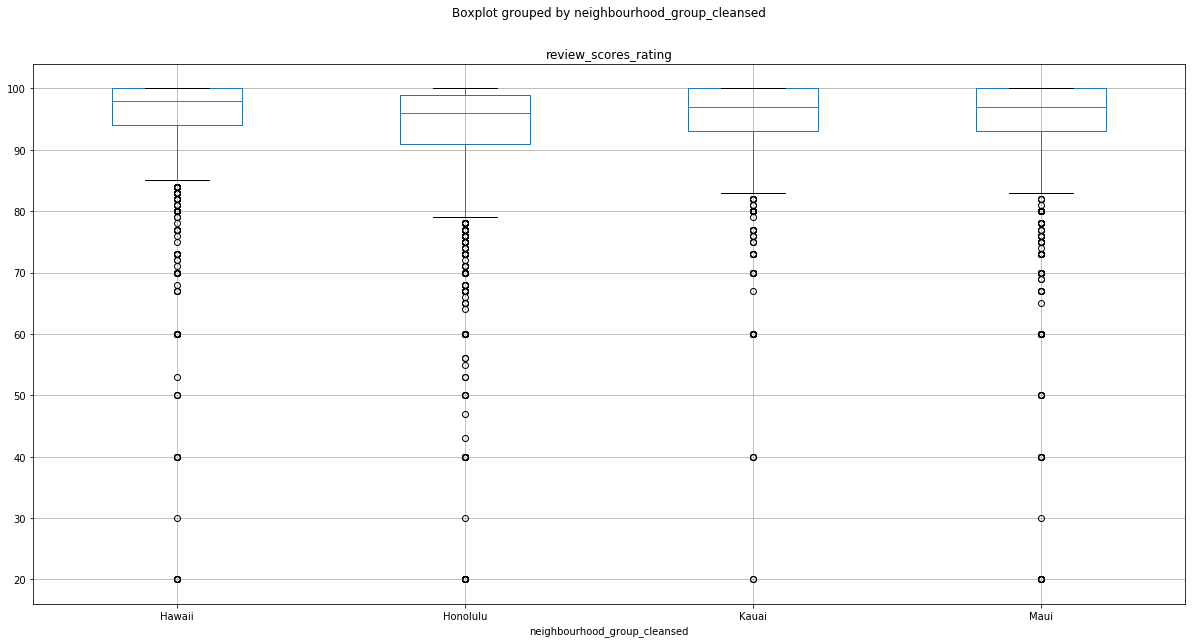

In [38]:
df.boxplot("review_scores_rating", by="neighbourhood_group_cleansed", figsize=(20, 10))

In [35]:
# Define a group by every rating properties
average_rating_prop = df.groupby("room_type").mean()["review_scores_rating"]
#property_type = df.groupby("property_type").count()["id"]

# dropped NaN values for property types that do not have ratings in hawaii such as 'igloo'
average_rating_prop = average_rating_prop.dropna()
average_rating_prop

room_type
Entire home/apt    94.737712
Hotel room         93.774038
Private room       94.951852
Shared room        91.917526
Name: review_scores_rating, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

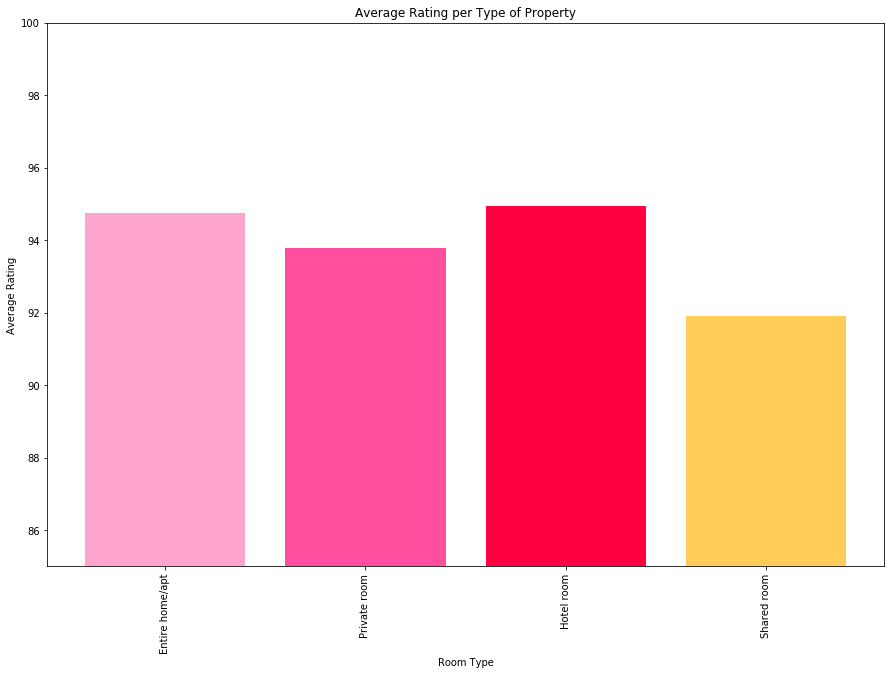

In [36]:
# set x and y axis for bar graph
x_axis = df["room_type"].unique()
y_axis = average_rating_prop

# print lables/title and x/y limits to improve visual
plt.subplots(figsize=(15,10))
plt.title("Average Rating per Type of Property")
plt.xlabel("Room Type")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(85, 100)

# display graph
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

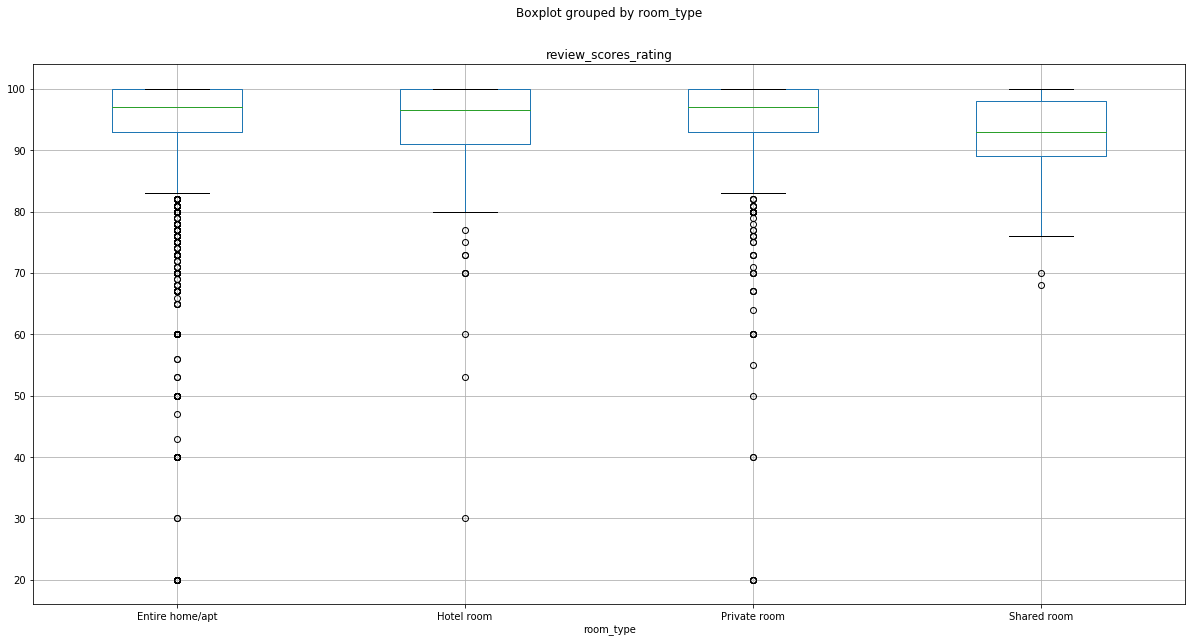

In [37]:
df.boxplot("review_scores_rating", by="room_type", figsize=(20, 10))

Text(0.5, 1.0, 'Property types availability in AirBnB')

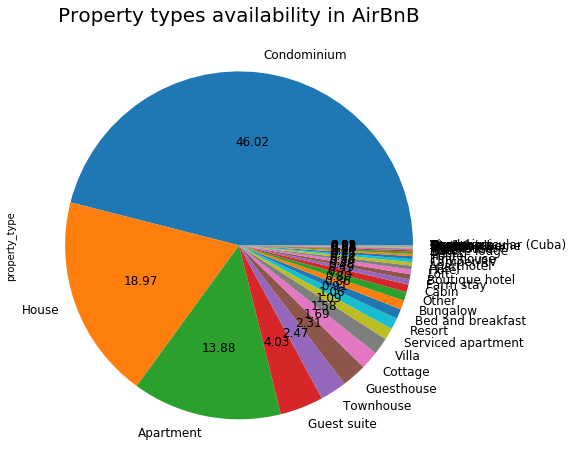

In [30]:
# Build a pie to show the availability by property type in Airbnb Hawaii.
prop_type_pie=df.property_type.value_counts()/len(df.property_type)
prop_type_pie.plot.pie(autopct='%.2f',fontsize=12,figsize=(8,8))
plt.title('Property types availability in AirBnB',fontsize=20)

Text(0.5, 1.0, 'Property Room Types Availability in AirBnB')

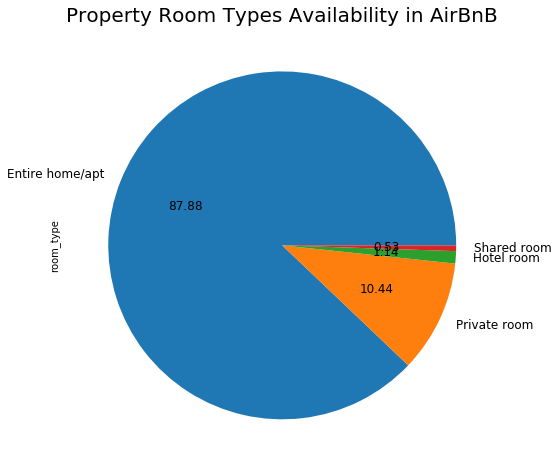

In [49]:
# Build a pie to show the availability by property room type in Airbnb Hawaii.
room_type_pie=df.room_type.value_counts()/len(df.room_type)
room_type_pie.plot.pie(autopct='%.2f',fontsize=12,figsize=(8,8))
plt.title('Property Room Types Availability in AirBnB',fontsize=20)

Text(0.5, 1.0, 'Neighbourhood groups Vs Room Types')

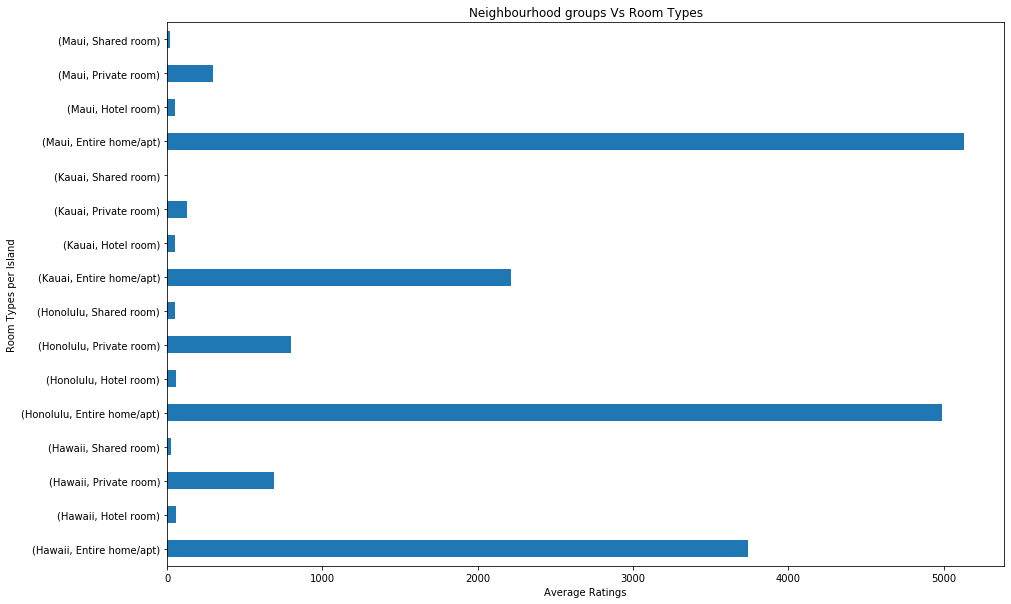

In [43]:
plt.subplots(figsize=(15,10))
df.groupby(['neighbourhood_group_cleansed','room_type']).room_type.count().plot.barh(stacked=True)
plt.ylabel('Room Types per Island')
plt.xlabel('Average Ratings')
plt.title('Neighbourhood groups Vs Room Types')

Text(0.5, 1.0, 'Neighbourhood groups Vs Room Types Availability')

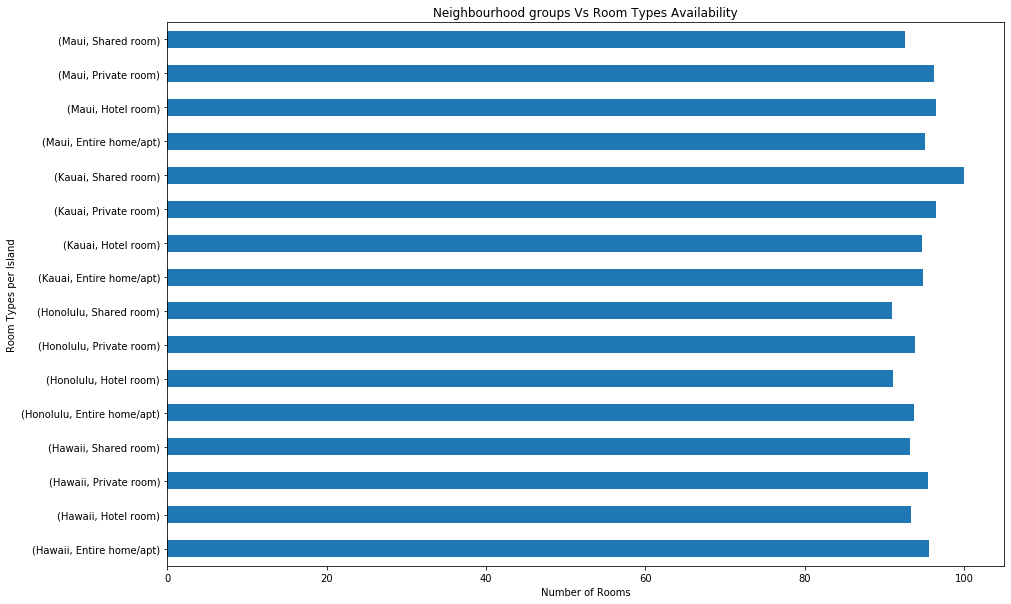

In [46]:
plt.subplots(figsize=(15,10))
df.groupby(['neighbourhood_group_cleansed','room_type']).review_scores_rating.mean().plot.barh(stacked=True)
plt.ylabel('Room Types per Island')
plt.xlabel('Number of Rooms')
plt.title('Neighbourhood groups Vs Room Types Availability')


In [50]:
plt.figure(figsize=(10,6))
plt.scatter(df.longitude, df.latitude, c=df.availability_365 , cmap='spring',\
            edgecolor='black', linewidth=1, alpha=0.75)

cbar = plt.colorbar()
cbar.set_label('availability_365')

AttributeError: 'DataFrame' object has no attribute 'availability_365'

<Figure size 720x432 with 0 Axes>